In [109]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# fetch dataset 
df = pd.read_excel('app_data.xlsx', sheet_name="All cases")
df = df[df['Diagnosis'].notna()]
  
# data (as pandas dataframes) 
X = df.drop(['Management','Severity','Diagnosis'], axis=1)
y = df['Diagnosis'].map({'appendicitis':1,'no appendicitis': 0 })



In [110]:
def load_and_examine_data(file_path):
    """
    Load the dataset and print basic information about it.
    """
    # Load the data
    df = pd.read_csv(file_path)
    
    # Basic dataset information
    print("\n=== Dataset Overview ===")
    print("\nDataset Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    print("\n=== Data Types ===")
    print(df.dtypes)
    
    return df

def generate_descriptive_stats(df):
    """
    Generate descriptive statistics for numerical columns
    """
    print("\n=== Descriptive Statistics ===")
    print(df.describe())
    
    # Additional statistics for numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        print(f"\nDetailed statistics for {col}:")
        print(f"Skewness: {df[col].skew():.2f}")
        print(f"Kurtosis: {df[col].kurtosis():.2f}")
        
def create_visualizations(df):
    """
    Create various visualizations for the dataset
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Distribution plots for numerical variables
    plt.figure(figsize=(15, 5*len(numerical_cols)))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols), 2, 2*i-1)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        
        plt.subplot(len(numerical_cols), 2, 2*i)
        sns.boxplot(data=df, y=col)
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Bar plots for categorical variables
    if len(categorical_cols) > 0:
        plt.figure(figsize=(12, 5*len(categorical_cols)))
        for i, col in enumerate(categorical_cols, 1):
            plt.subplot(len(categorical_cols), 1, i)
            sns.countplot(data=df, x=col)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [111]:
# Generate descriptive statistics
generate_descriptive_stats(X)


=== Descriptive Statistics ===
              Age         BMI      Height      Weight  Length_of_Stay  \
count  780.000000  754.000000  755.000000  778.000000      777.000000   
mean    11.341863   18.905041  147.997616   43.158625        4.285714   
std      3.529881    4.387860   19.737546   17.397830        2.575302   
min      0.000000    7.827983   53.000000    3.960000        1.000000   
25%      9.198426   15.721375  137.000000   29.500000        3.000000   
50%     11.437372   18.044121  149.500000   41.300000        3.000000   
75%     14.040383   21.185877  163.000000   54.000000        5.000000   
max     18.360000   38.156221  192.000000  103.000000       28.000000   

       Alvarado_Score  Paedriatic_Appendicitis_Score  Appendix_Diameter  \
count      730.000000                     730.000000         498.000000   
mean         5.921918                       5.253425           7.762651   
std          2.155972                       1.958456           2.536671   
min       

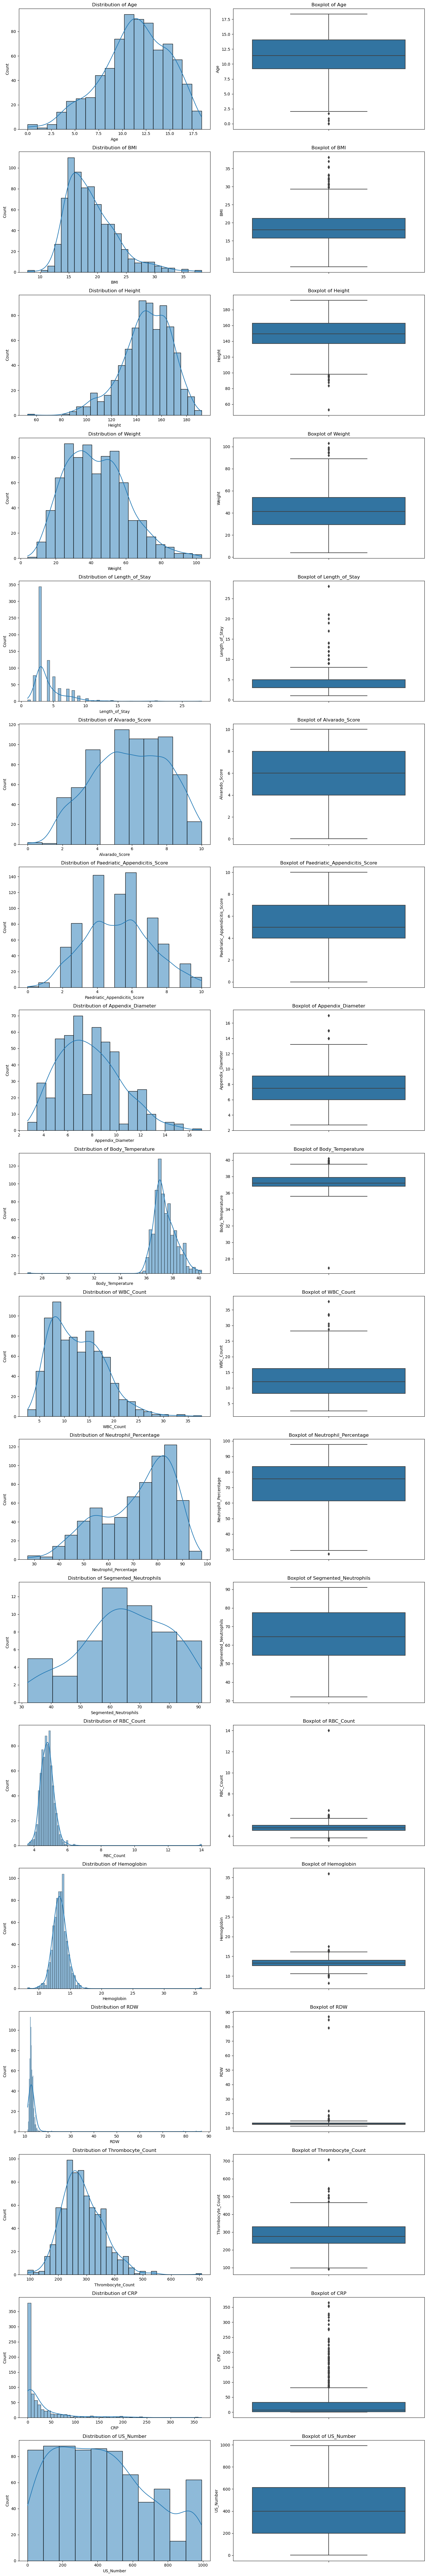

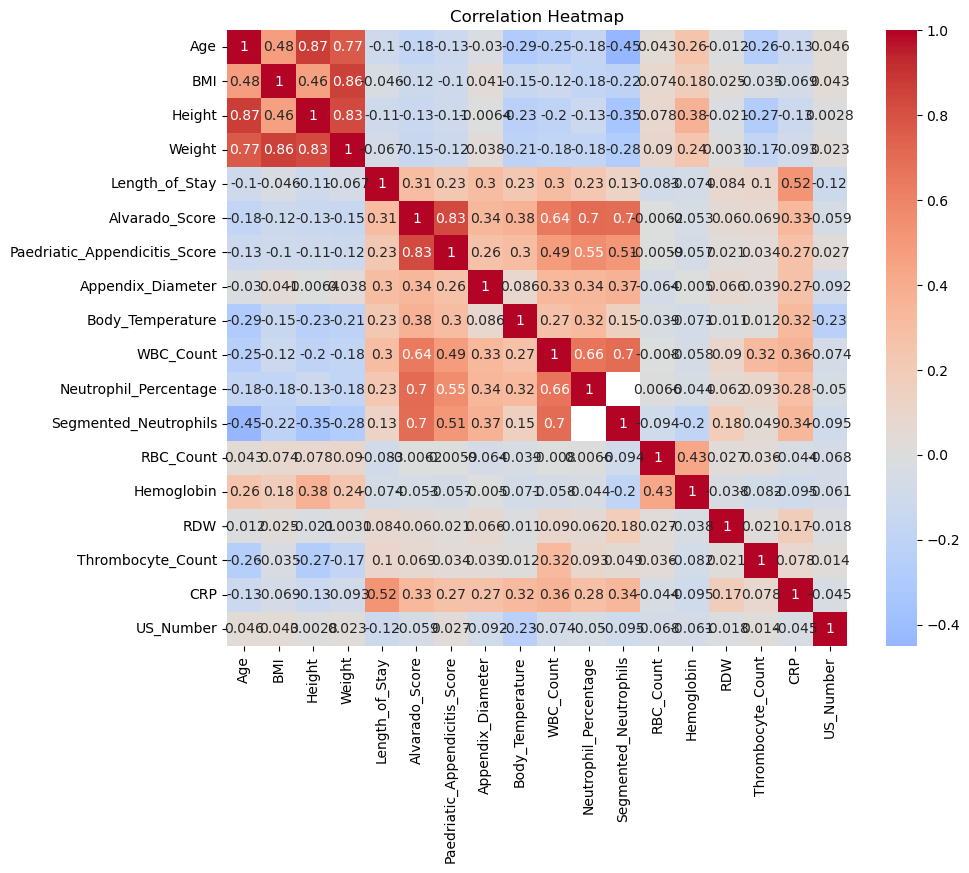

/var/folders/rn/lw14788970q63g4pdwnl_3_w0000gn/T/ipykernel_49369/2974988039.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


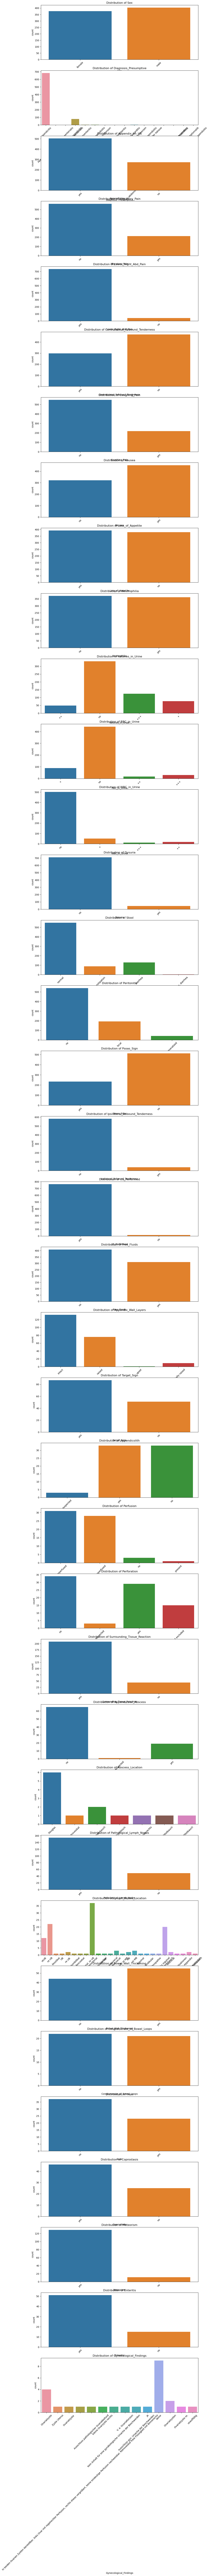

In [112]:
create_visualizations(X)

The pipeline will:

- Automatically identify numerical and categorical columns
- Handle missing values
- Apply the specified normalization to numerical features
- Encode categorical variables using the chosen method
- Optionally reduce dimensions using PCA
- Provide visualizations of the PCA results

In [113]:
class DataPreprocessor:
    def __init__(self, normalization_method='standard', categorical_method='onehot', 
                 reduce_dimensions=True, n_components=None, random_state=42):
        """
        Initialize the preprocessor with specified methods
        
        Parameters:
        - normalization_method: 'standard' or 'minmax'
        - categorical_method: 'label' or 'onehot'
        - reduce_dimensions: boolean, whether to apply PCA
        - n_components: int or float, number of components for PCA
        """
        self.normalization_method = normalization_method
        self.categorical_method = categorical_method
        self.reduce_dimensions = reduce_dimensions
        self.n_components = n_components
        self.random_state = random_state
        
        # Initialize transformers
        self.numerical_transformer = None
        self.categorical_transformer = None
        self.pca = None
        
        # Store column information
        self.numerical_columns = None
        self.categorical_columns = None
        
    def identify_column_types(self, df):
        """Identify numerical and categorical columns"""
        self.numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
        self.categorical_columns = df.select_dtypes(include=['object', 'category']).columns
        
        print("Numerical columns:", list(self.numerical_columns))
        print("Categorical columns:", list(self.categorical_columns))
        
    def create_preprocessors(self):
        """Create preprocessing transformers based on specified methods"""
        # Numerical preprocessing
        if self.normalization_method == 'standard':
            self.numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])
        else:  # minmax
            self.numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', MinMaxScaler())
            ])
            
        # Categorical preprocessing
        if self.categorical_method == 'label':
            self.categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('label_encoder', LabelEncoder())
            ])
        else:  # onehot
            self.categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(drop='first', sparse=False))
            ])
    
    def fit_transform(self, df):
        """Fit and transform the data"""
        # Identify column types
        self.identify_column_types(df)
        
        # Create preprocessors
        self.create_preprocessors()
        
        # Process numerical data
        numerical_data = None
        if len(self.numerical_columns) > 0:
            numerical_data = self.numerical_transformer.fit_transform(df[self.numerical_columns])
            numerical_data = pd.DataFrame(numerical_data, 
                                        columns=self.numerical_columns)
        
        # Process categorical data
        categorical_data = None
        if len(self.categorical_columns) > 0:
            if self.categorical_method == 'label':
                categorical_data = pd.DataFrame()
                for col in self.categorical_columns:
                    categorical_data[col] = self.categorical_transformer.fit_transform(df[col])
            else:  # onehot
                categorical_data = self.categorical_transformer.fit_transform(df[self.categorical_columns])
                # Get feature names after one-hot encoding
                feature_names = self.categorical_transformer.named_steps['onehot'].get_feature_names_out(self.categorical_columns)
                categorical_data = pd.DataFrame(categorical_data, columns=feature_names)
        
        # Combine processed data
        processed_data = pd.concat([numerical_data, categorical_data], axis=1)
        
        # Apply dimension reduction if specified
        if self.reduce_dimensions:
            self.pca = PCA(n_components=self.n_components, random_state=self.random_state)
            reduced_data = self.pca.fit_transform(processed_data)
            
            # Create DataFrame with PCA components
            columns = [f'PC{i+1}' for i in range(reduced_data.shape[1])]
            processed_data = pd.DataFrame(reduced_data, columns=columns)
            
            # Plot explained variance ratio
            self.plot_explained_variance()
        
        return processed_data
    
    def plot_explained_variance(self):
        """Plot the explained variance ratio for PCA components"""
        if self.pca is not None:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(self.pca.explained_variance_ratio_) + 1),
                    np.cumsum(self.pca.explained_variance_ratio_), 'bo-')
            plt.xlabel('Number of Components')
            plt.ylabel('Cumulative Explained Variance Ratio')
            plt.title('Explained Variance Ratio vs Number of Components')
            plt.grid(True)
            plt.show()
            
            # Print explained variance ratio
            print("\nExplained variance ratio by component:")
            for i, ratio in enumerate(self.pca.explained_variance_ratio_):
                print(f"PC{i+1}: {ratio:.4f}")


Numerical columns: ['Age', 'BMI', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_Diameter', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'CRP', 'US_Number']
Categorical columns: ['Sex', 'Diagnosis_Presumptive', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Neutrophilia', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis', 'G

/Users/brandonmontoyalopez/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


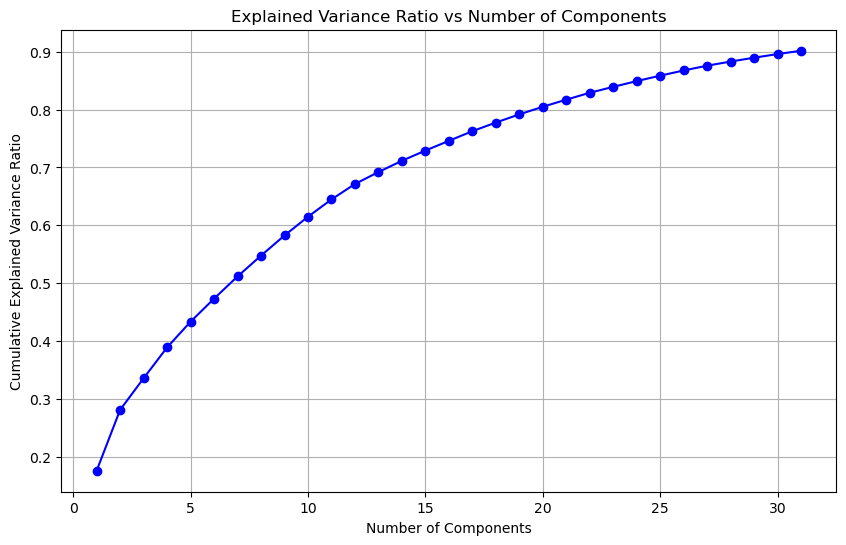


Explained variance ratio by component:
PC1: 0.1761
PC2: 0.1052
PC3: 0.0546
PC4: 0.0533
PC5: 0.0444
PC6: 0.0398
PC7: 0.0384
PC8: 0.0359
PC9: 0.0348
PC10: 0.0324
PC11: 0.0299
PC12: 0.0266
PC13: 0.0207
PC14: 0.0195
PC15: 0.0177
PC16: 0.0168
PC17: 0.0167
PC18: 0.0149
PC19: 0.0142
PC20: 0.0131
PC21: 0.0123
PC22: 0.0119
PC23: 0.0102
PC24: 0.0099
PC25: 0.0094
PC26: 0.0089
PC27: 0.0083
PC28: 0.0071
PC29: 0.0067
PC30: 0.0063
PC31: 0.0057


In [114]:
# Create preprocessor
preprocessor = DataPreprocessor(
    normalization_method='standard',  # or 'minmax'
    categorical_method='onehot',      # or 'label'
    reduce_dimensions=True,
    n_components=0.90                 # Keep components explaining 90% of variance
)

# Fit and transform data
processed_data = preprocessor.fit_transform(X)

In [115]:
class MLPipeline:
    def __init__(self, random_state=42):
        """Initialize the ML pipeline with various models and their parameter grids"""
        self.random_state = random_state
        self.models = {
            'logistic_regression': {
                'model': LogisticRegression(random_state=random_state),
                'params': {
                    'C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear', 'saga']
                }
            },
            'decision_tree': {
                'model': DecisionTreeClassifier(random_state=random_state),
                'params': {
                    'max_depth': [3, 5, 7, 10],
                    'min_samples_split': [2, 5, 10],
                    'criterion': ['gini', 'entropy']
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(random_state=random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'svm': {
                'model': SVC(random_state=random_state),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf'],
                    'gamma': ['scale', 'auto']
                }
            },
            'knn': {
                'model': KNeighborsClassifier(),
                'params': {
                    'n_neighbors': [3, 5, 7, 9],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'manhattan']
                }
            }
        }
        self.best_models = {}
        
    def split_data(self, X, y, test_size=0.2):
        """Split data into training and testing sets"""
        return train_test_split(X, y, test_size=test_size, random_state=self.random_state)
        
    def evaluate_models(self, X_train, X_test, y_train, y_test, cv=5):
        """Evaluate all models using cross-validation"""
        results = {}
        
        for name, model_info in self.models.items():
            model = model_info['model']
            # Perform cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
            
            # Fit model and make predictions
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Store results
            results[name] = {
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'test_accuracy': accuracy_score(y_test, y_pred)
            }
        
        return results
    
    def plot_model_comparison(self, results):
        """Plot comparison of model performances"""
        plt.figure(figsize=(12, 6))
        
        # Prepare data for plotting
        models = list(results.keys())
        cv_means = [results[m]['cv_mean'] for m in models]
        cv_stds = [results[m]['cv_std'] for m in models]
        test_scores = [results[m]['test_accuracy'] for m in models]
        
        # Create bar plot
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, cv_means, width, label='Cross-validation Score',
                yerr=cv_stds, capsize=5)
        plt.bar(x + width/2, test_scores, width, label='Test Score')
        
        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Model Performance Comparison')
        plt.xticks(x, models, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def tune_hyperparameters(self, X_train, y_train, cv=5):
        """Perform hyperparameter tuning using GridSearchCV"""
        tuned_models = {}
        
        for name, model_info in self.models.items():
            print(f"\nTuning {name}...")
            grid_search = GridSearchCV(
                model_info['model'],
                model_info['params'],
                cv=cv,
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X_train, y_train)
            
            tuned_models[name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'best_model': grid_search.best_estimator_
            }
            
        self.best_models = tuned_models
        return tuned_models
    
    def plot_confusion_matrix(self, model, X_test, y_test, title='Confusion Matrix'):
        """Plot confusion matrix for a given model"""
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print classification report
        print('\nClassification Report:')
        print(classification_report(y_test, y_pred))
    
    def evaluate_best_model(self, X_test, y_test):
        """Evaluate and compare the best models after tuning"""
        results = {}
        
        for name, model_info in self.best_models.items():
            best_model = model_info['best_model']
            y_pred = best_model.predict(X_test)
            
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'best_params': model_info['best_params']
            }
            
            print(f"\nResults for {name}:")
            print(f"Best Parameters: {model_info['best_params']}")
            print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
            
            # Plot confusion matrix
            self.plot_confusion_matrix(best_model, X_test, y_test, 
                                     title=f'Confusion Matrix - {name}')
        
        return results


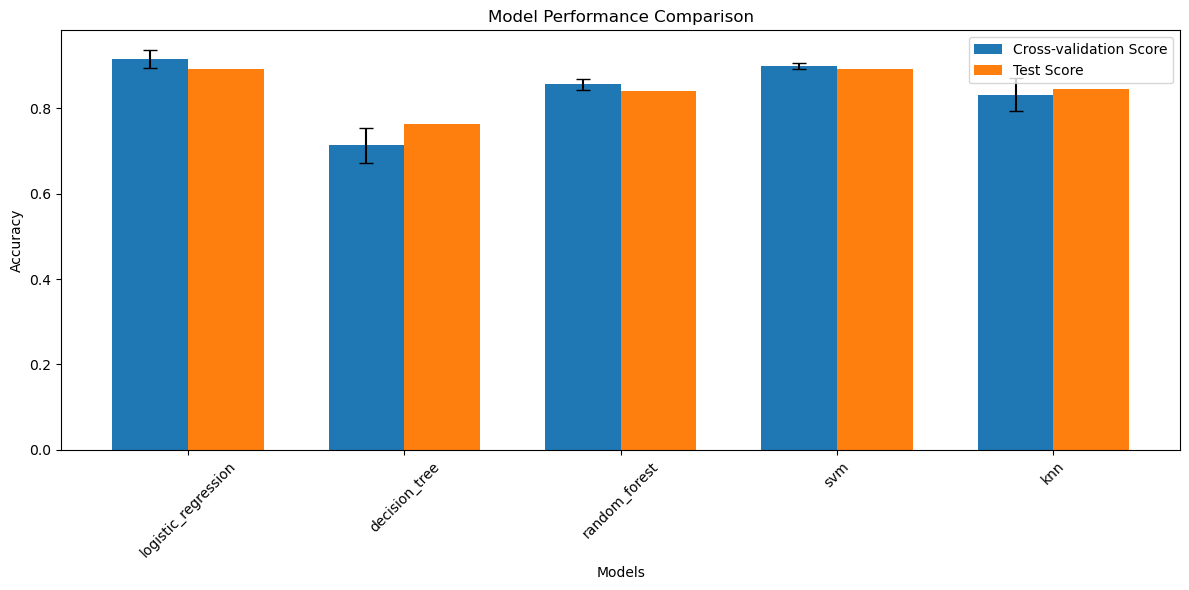

In [122]:
# Initialize pipeline
pipeline = MLPipeline()

# Split your data
X_train, X_test, y_train, y_test = pipeline.split_data(processed_data, y)

# Initial model evaluation
results = pipeline.evaluate_models(X_train, X_test, y_train, y_test)
pipeline.plot_model_comparison(results)




Tuning logistic_regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Tuning decision_tree...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/brandonmontoyalopez/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/brandonmontoyalopez/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/brandonmontoyalopez/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/brandonmontoyalopez/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/brandonmontoyalopez/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


Tuning random_forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Tuning svm...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Tuning knn...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Results for logistic_regression:
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Test Accuracy: 0.8718


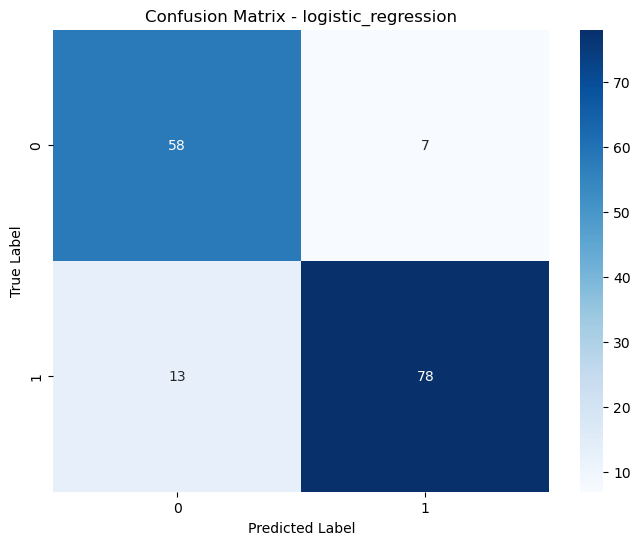


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        65
           1       0.92      0.86      0.89        91

    accuracy                           0.87       156
   macro avg       0.87      0.87      0.87       156
weighted avg       0.88      0.87      0.87       156


Results for decision_tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}
Test Accuracy: 0.7244


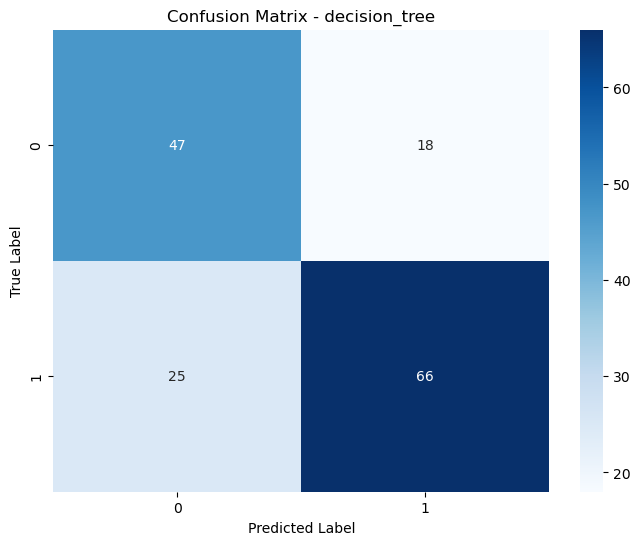


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.69        65
           1       0.79      0.73      0.75        91

    accuracy                           0.72       156
   macro avg       0.72      0.72      0.72       156
weighted avg       0.73      0.72      0.73       156


Results for random_forest:
Best Parameters: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 300}
Test Accuracy: 0.8654


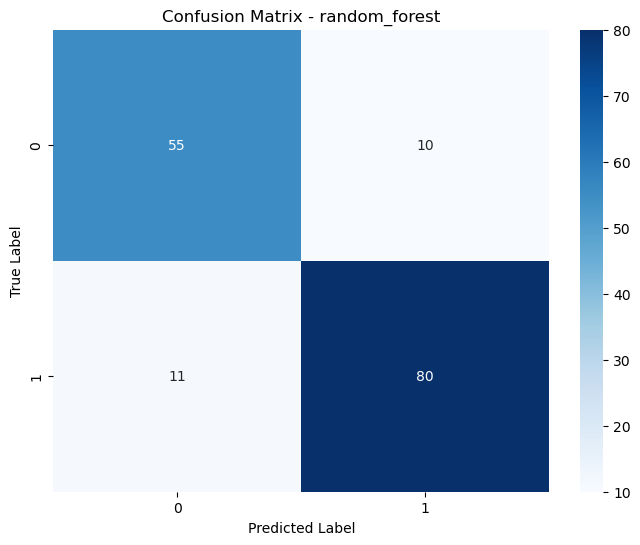


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        65
           1       0.89      0.88      0.88        91

    accuracy                           0.87       156
   macro avg       0.86      0.86      0.86       156
weighted avg       0.87      0.87      0.87       156


Results for svm:
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.8974


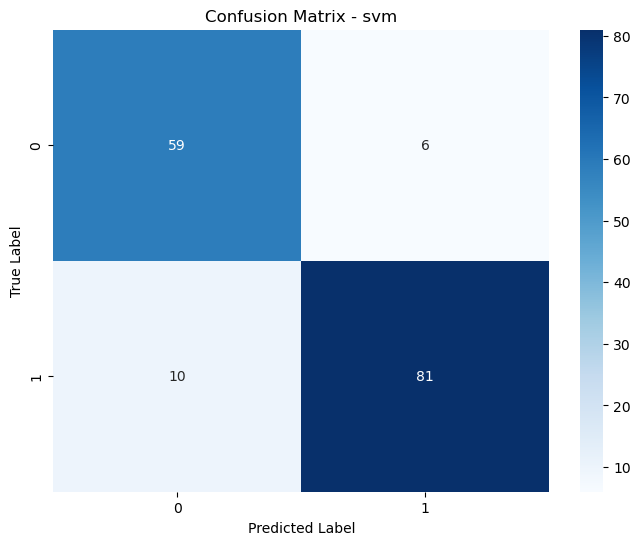


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        65
           1       0.93      0.89      0.91        91

    accuracy                           0.90       156
   macro avg       0.89      0.90      0.90       156
weighted avg       0.90      0.90      0.90       156


Results for knn:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Test Accuracy: 0.8718


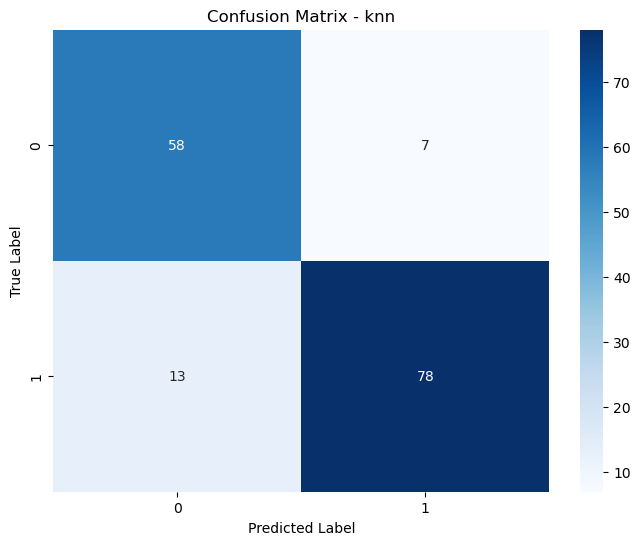


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        65
           1       0.92      0.86      0.89        91

    accuracy                           0.87       156
   macro avg       0.87      0.87      0.87       156
weighted avg       0.88      0.87      0.87       156



In [123]:
# Tune hyperparameters
tuned_models = pipeline.tune_hyperparameters(X_train, y_train)

# Evaluate best models
final_results = pipeline.evaluate_best_model(X_test, y_test)